In [ ]:
# google cloud lib req
#!pip install --user gcsfs statsmodels

In [1]:
# Import Libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
import warnings
warnings.filterwarnings("ignore")

In [2]:
#  Load the Data using Apple’s stock price data over the last 10 years, stored in a Google Cloud Storage bucket.
#df = pd.read_csv('gs://cloud-training/ai4f/AAPL10Y.csv')
df = pd.read_csv('aapl_2014_2023.csv')
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)
df.head()

,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,ema_50,sma_100,ema_100,macd,bollinger,TrueRange,atr_7,atr_14,target
date,,,,,,,,,,,,,,,,,,,
2014-01-02,19.845715,19.893929,19.715000,19.754642,234684800,44.149614,50.996175,-105.071637,-42.411877,19.282236,19.265060,18.372604,18.484713,0.194637,19.979268,0.321428,0.305722,0.316301,bearish
2014-01-03,19.745001,19.775000,19.301071,19.320715,392467600,33.094332,43.883529,-152.150999,-124.511983,19.297314,19.267243,18.398896,18.501371,0.132887,19.936375,0.473929,0.329752,0.327561,bullish
2014-01-06,19.194643,19.528570,19.057142,19.426071,412610800,37.525661,45.858019,-132.306490,-130.122350,19.310864,19.273472,18.418311,18.519794,0.091398,19.893571,0.471428,0.349991,0.337837,bearish
2014-01-07,19.440001,19.498571,19.211430,19.287144,317209200,34.055624,43.675708,-89.587009,-108.089019,19.316671,19.274008,18.433146,18.535080,0.046768,19.857893,0.287141,0.341013,0.334216,bullish
2014-01-08,19.243214,19.484285,19.238930,19.409286,258529600,39.768497,46.104107,-58.525539,-82.150032,19.329171,19.279313,18.449414,18.552493,0.021012,19.816875,0.245355,0.327347,0.327868,bearish


In [3]:
# Select only the specified columns
df_selected = df[['close']]
# Display the result
df_selected.head()

,close
date,
2014-01-02,19.754642
2014-01-03,19.320715
2014-01-06,19.426071
2014-01-07,19.287144
2014-01-08,19.409286


In [4]:
# Resample the data to weekly frequency and take the mean of 'close'
#df['close'] = pd.to_numeric(df['close'], errors='coerce')# Convert 'close' to numeric in case it's not in numeric format
df_week = df_selected.resample('W').mean()
df_week.head()

,close
date,
2014-01-05,19.537678
2014-01-12,19.263500
2014-01-19,19.531429
2014-01-26,19.668126
2014-02-02,18.272357


In [5]:
#  computing the logarithmic weekly returns to normalize the data.
df_week['weekly_ret'] = np.log(df_week['close']).diff()
df_week.dropna(inplace=True)
df_week.head()

,close,weekly_ret
date,,
2014-01-12,19.263500,-0.014133
2014-01-19,19.531429,0.013813
2014-01-26,19.668126,0.006974
2014-02-02,18.272357,-0.073610
2014-02-09,18.250714,-0.001185


# Exploratory Data Analysis

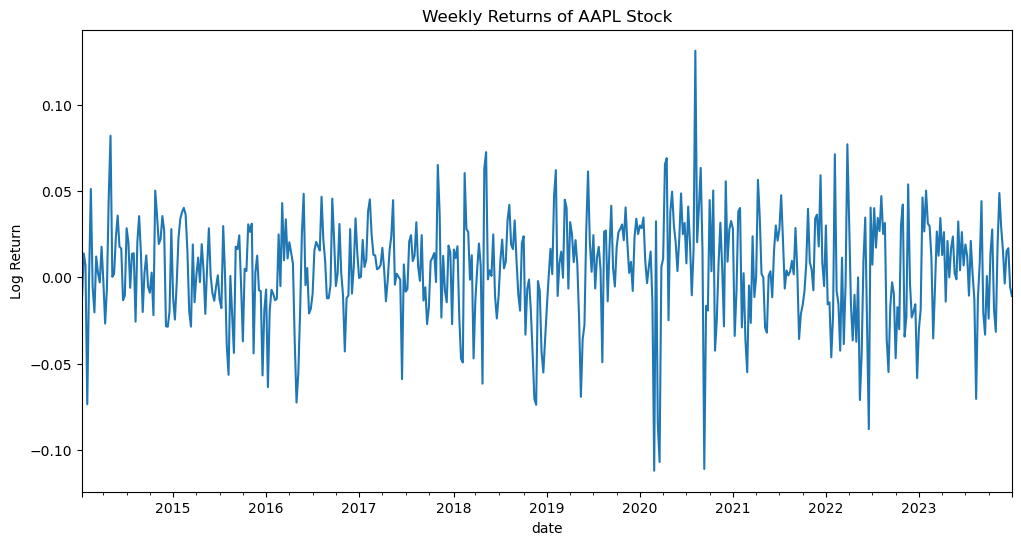

In [6]:
# visualizing the weekly returns.
df_week['weekly_ret'].plot(kind='line', figsize=(12, 6))
plt.title('Weekly Returns of AAPL Stock')
plt.ylabel('Log Return')
plt.show()

# Testing for Stationarity
- stationary time series has a constant mean and variance over time, which is a prerequisite for ARIMA modelling.
- computing the rolling mean and standard deviation.

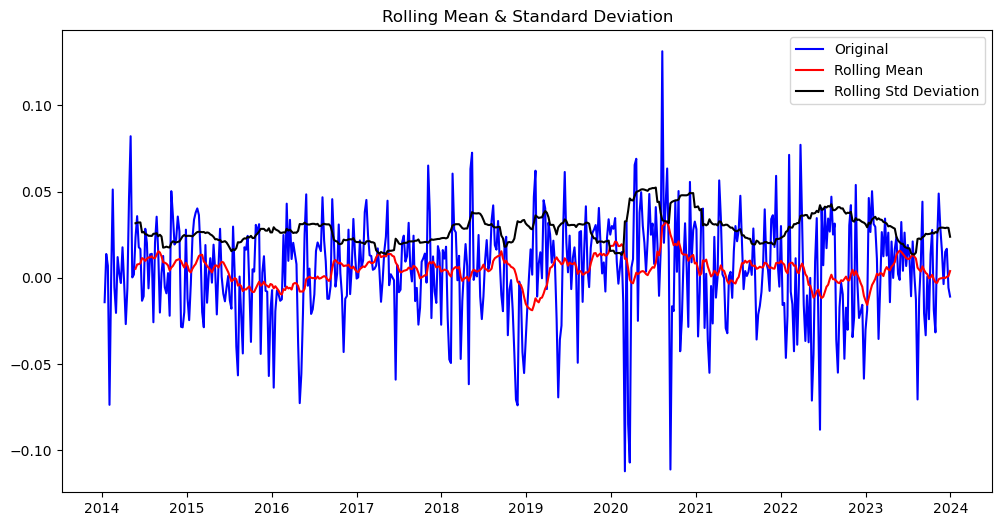

In [7]:
rolmean = df_week['weekly_ret'].rolling(window=20).mean()
rolstd = df_week['weekly_ret'].rolling(window=20).std()

plt.figure(figsize=(12, 6))
plt.plot(df_week['weekly_ret'], color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

In [8]:
# Augmented Dickey-Fuller test to statistically check stationarity.
dftest = sm.tsa.adfuller(df_week['weekly_ret'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
print(dfoutput)

Test Statistic                -1.464198e+01
p-value                        3.611773e-27
# Lags Used                    1.000000e+00
Number of Observations Used    5.190000e+02
Critical Value (1%)           -3.443013e+00
Critical Value (5%)           -2.867125e+00
Critical Value (10%)          -2.569745e+00
dtype: float64


Interpretation:
- If the p-value is less than 0.05, the time series is stationary.

- Test Statistic: The test statistic is approximately -14.64, which is much lower than any of the critical values at the 1%, 5%, and 10% significance levels.
- p-value: The p-value is extremely low (3.61×10 −27), which is well below the typical significance levels (e.g., 0.05 or 0.01). **This indicates that we can reject the null hypothesis of non-stationarity.**
- Critical Values: The test statistic is significantly lower than the critical values at all tested levels (1%, 5%, and 10%), reinforcing the conclusion that the data is stationary.
  
**In summary, both the p-value and the test statistic strongly suggest rejecting the null hypothesis, indicating that the data is stationary. Hence we can proceed with the ARIMA forecasting**

# Identifying ARIMA Parameters
- to identify the optimal ARIMA parameters (p, d, q) for the  dataset.
- This process involves using the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to help determine suitable values for p and q, while d is set based on the stationarity of the data.
- ACF and PACF Analysis: These plots help us visually decide on the values of p and q. The ACF shows the correlation of a time series with its lagged values, helping identify the q parameter, and the PACF helps determine p

In [9]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf, pacf

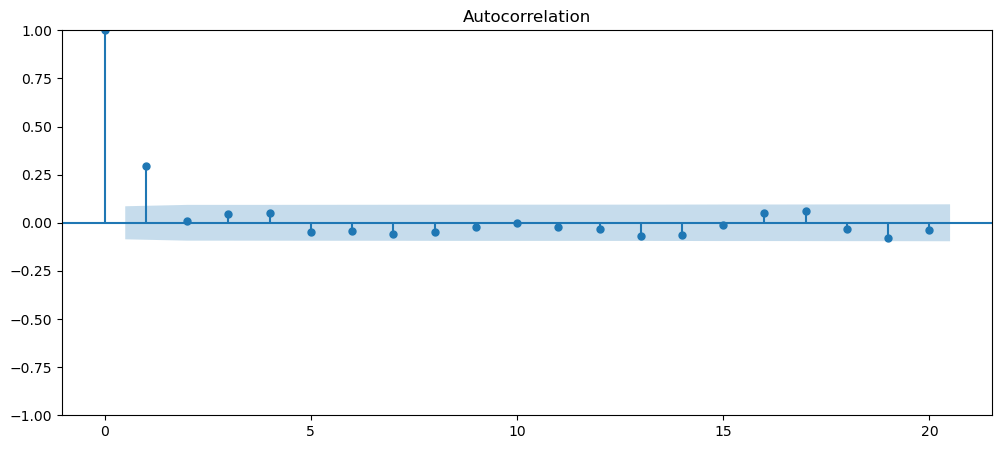

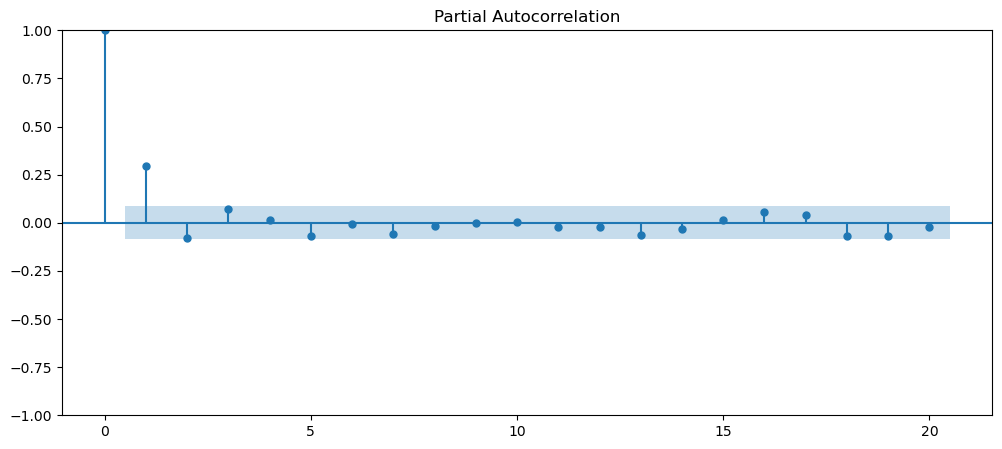

In [10]:
# Step 1: Plot ACF to estimate q
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(df_week['weekly_ret'], lags=20, ax=ax)
plt.show()

# Step 2: Plot PACF to estimate p
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(df_week['weekly_ret'], lags=20, ax=ax)
plt.show()

In [11]:
acf_values = acf(df_week['weekly_ret'], nlags=20)  # Adjust `nlags` as needed
pacf_values = pacf(df_week['weekly_ret'], nlags=20)  # Adjust `nlags` as needed

# Display the values
acf_values_df = pd.DataFrame({'Lag': range(len(acf_values)), 'ACF': acf_values})
pacf_values_df = pd.DataFrame({'Lag': range(len(pacf_values)), 'PACF': pacf_values})
print("ACF values:\n", acf_values_df)
print("\nPACF values:\n", pacf_values_df)

ACF values:
     Lag       ACF
0     0  1.000000
1     1  0.293244
2     2  0.011610
3     3  0.044942
4     4  0.048696
5     5 -0.047868
6     6 -0.044615
7     7 -0.059830
8     8 -0.048915
9     9 -0.022038
10   10 -0.003694
11   11 -0.021683
12   12 -0.031183
13   13 -0.066116
14   14 -0.063566
15   15 -0.010059
16   16  0.051564
17   17  0.060785
18   18 -0.032262
19   19 -0.078831
20   20 -0.038748

PACF values:
     Lag      PACF
0     0  1.000000
1     1  0.293808
2     2 -0.081723
3     3  0.072180
4     4  0.016008
5     5 -0.072002
6     6 -0.007425
7     7 -0.058451
8     8 -0.014878
9     9  0.000460
10   10  0.002696
11   11 -0.020060
12   12 -0.024430
13   13 -0.064757
14   14 -0.035320
15   15  0.016835
16   16  0.055778
17   17  0.041532
18   18 -0.073100
19   19 -0.070443
20   20 -0.021411


*Observation*
- ACF and PACF Analysis: These plots help us visually decide on the values of p and q. The ACF shows the correlation of a time series with its lagged values, helping identify the q parameter, and the PACF helps determine p
- Based on the ACF and PACF patterns:
p = 1 (AR term from PACF)
q = 1 (MA term from ACF)
d = 0 (assuming stationarity based on previous results).

# Hyperparameter Tuning
- to automate finding the best (p, d, q), we can run a grid search over a range of values and select the parameters with the lowest AIC (Akaike Information Criterion) and MSE (Mean Squared Error).
- To enhance ARIMA model selection process by incorporating Mean Squared Error (MSE) along with Akaike Information Criterion (AIC).
- This approach ensures that I select the best ARIMA model based on both AIC (which indicates model fit) and MSE (which measures forecasting accuracy).
- divide the dataset into a training set (60%) and a testing set (40%).
- fit model on the training set and forecast values for the testing set.bMSE is calculated between the actual test values and the predicted values.
- model with the lowest AIC is retained. In case of ties in AIC, it favours the one with the lowest MSE.

In [12]:
# Assuming df_week is your DataFrame and 'weekly_ret' is the column of interest
# Set initial range for p, d, and q
p = range(0, 4)  # Adjust range if necessary
d = range(0, 1)  # Typically, d = 0 or 1 if data is stationary
q = range(0, 4)

# Prepare to store the best results
best_aic = float("inf")
best_mse = float("inf")
best_order = None

# Grid search over the p, d, q values
for i in p:
    for j in d:
        for k in q:
            try:
                # Fit the ARIMA model
                model = ARIMA(df_week['weekly_ret'], order=(i, j, k))
                model_fit = model.fit()

                # Calculate AIC
                aic = model_fit.aic

                # Make predictions for MSE calculation (using the last 10% of the data as test set)
                train_size = int(len(df_week) * 0.9)
                train, test = df_week['weekly_ret'][:train_size], df_week['weekly_ret'][train_size:]
                model = ARIMA(train, order=(i, j, k))
                model_fit = model.fit()

                # Forecast the test set
                predictions = model_fit.forecast(steps=len(test))
                mse = mean_squared_error(test, predictions)

                # Check for best AIC and MSE
                if aic < best_aic or (aic == best_aic and mse < best_mse):
                    best_aic = aic
                    best_mse = mse
                    best_order = (i, j, k)

            except Exception as e:
                # Catch exceptions related to model fitting
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic} and MSE: {best_mse}")

Best ARIMA order: (0, 0, 1) with AIC: -2232.9977385600246 and MSE: 0.0005706296022557562


# Fit the Best ARIMA Model

In [13]:
# Fit model with best (p, d, q) parameters
best_model = ARIMA(df_week['weekly_ret'], order=best_order).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:             weekly_ret   No. Observations:                  521
Model:                 ARIMA(0, 0, 1)   Log Likelihood                1119.499
Date:                Sun, 03 Nov 2024   AIC                          -2232.998
Time:                        18:36:05   BIC                          -2220.230
Sample:                    01-12-2014   HQIC                         -2227.997
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.622      0.009       0.001       0.008
ma.L1          0.3238      0.032     10.135      0.000       0.261       0.386
sigma2         0.0008    3.7e-05     21.502      0.0

In [ ]:
# Fit model with best (p, d, q) parameters
#best_p, best_d, best_q = best_model[0]
#best_model = ARIMA(df_week['weekly_ret'], order=(best_p, best_d, best_q)).fit()
#print(best_model.summary())

Ljung-Box Test (L1, Q): The Ljung-Box Q statistic tests for autocorrelation in the residuals at lag 1.
- With a Q-statistic close to 0 and a high p-value (0.95), there’s no evidence of autocorrelation in the residuals, suggesting that the model captures the autocorrelation structure well.
- Kurtosis: 4.61 This measures the "tailedness" of the distribution. A value greater than 3 indicates a heavier tail than a normal distribution.

Overall, the model fits the data reasonably well, but there are indications of non-normality in the residuals and potential heteroskedasticity. Might have to consider model diagnostics further or explore different specifications or transformations of the data to address these issues.

# Model Evaluation
- Residual Analysis
- Forecast Future Values
- Inverse Transform to Price

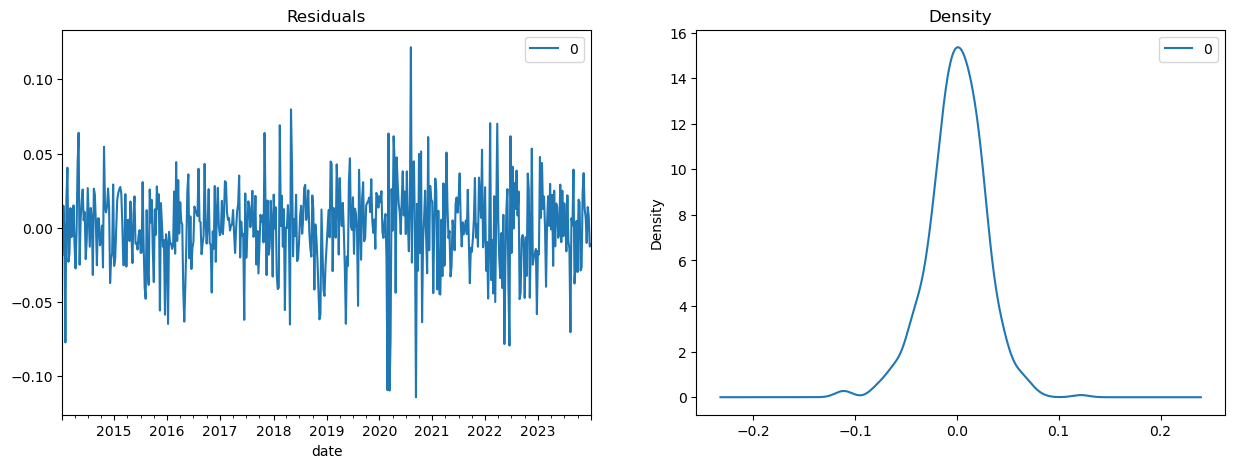

In [14]:
# Residual Analysis: to ensure they are randomly distributed (white noise).

residuals = pd.DataFrame(best_model.resid)
fig, ax = plt.subplots(1,2, figsize=(15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Residual Plot: Shows how well the ARIMA model fits the data over time. The residuals (errors) fluctuate around zero without an obvious pattern, which is a good sign. It means the model's doing a decent job.

Density Plot: Shows the distribution of these residuals. Most residuals are close to zero and the shape of the plot looks roughly symmetric, which suggests that the residuals are normally distributed. This is also a positive indicator that the model’s assumptions hold true.

Both plots show that the ARIMA model has captured the data's structure well.

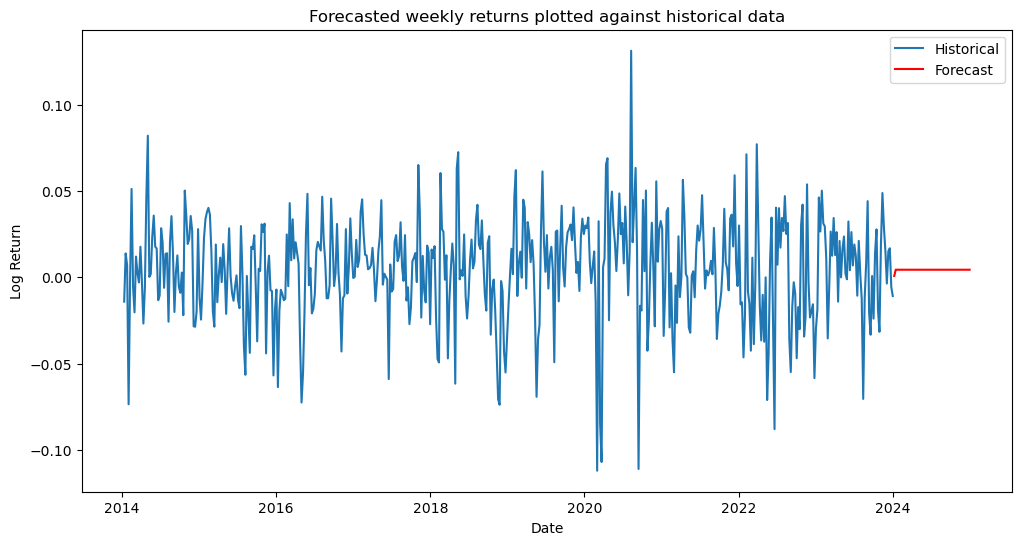

In [15]:
forecast_steps = 52
forecast = best_model.forecast(steps=forecast_steps)

plt.figure(figsize=(12, 6))
plt.plot(df_week['weekly_ret'], label='Historical')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title('Forecasted weekly returns plotted against historical data')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.show()

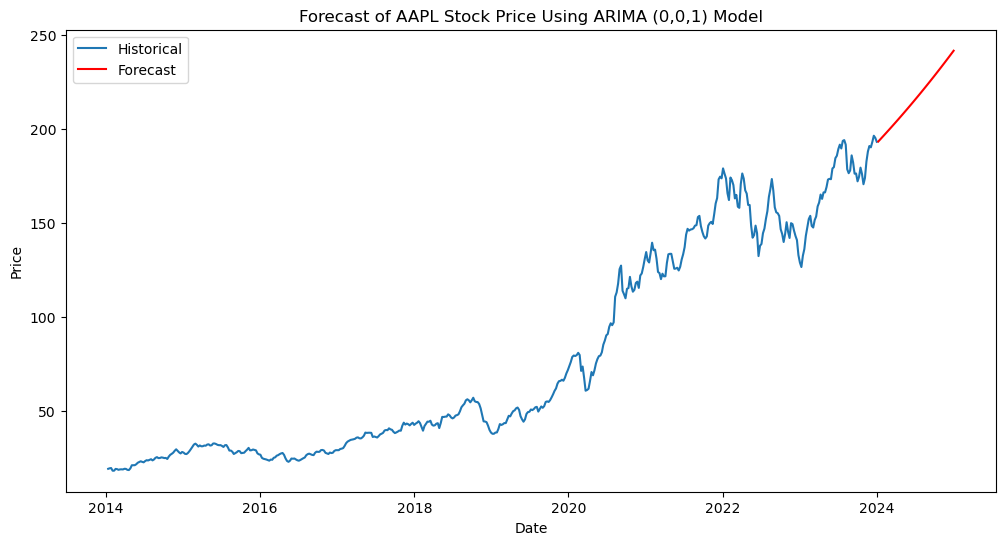

In [18]:
# Inverse Transform to Price: To make the forecast interpretable, we convert the returns back to price levels.
last_close = df_week['close'][-1]
forecast_prices = last_close * np.exp(np.cumsum(forecast))

plt.figure(figsize=(12, 6))
plt.plot(df_week['close'], label='Historical')
plt.plot(forecast.index, forecast_prices, label='Forecast', color='red')
plt.title('Forecast of AAPL Stock Price Using ARIMA (0,0,1) Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [17]:
# Print the forecasted values
print("Forecasted Returns for the Next 52 Weeks:")
print(forecast_prices)

Forecasted Returns for the Next 52 Weeks:
2024-01-07    193.224830
2024-01-14    194.071526
2024-01-21    194.921933
2024-01-28    195.776066
2024-02-04    196.633941
2024-02-11    197.495576
2024-02-18    198.360986
2024-02-25    199.230189
2024-03-03    200.103200
2024-03-10    200.980037
2024-03-17    201.860716
2024-03-24    202.745254
2024-03-31    203.633668
2024-04-07    204.525975
2024-04-14    205.422192
2024-04-21    206.322337
2024-04-28    207.226425
2024-05-05    208.134475
2024-05-12    209.046505
2024-05-19    209.962530
2024-05-26    210.882570
2024-06-02    211.806641
2024-06-09    212.734761
2024-06-16    213.666949
2024-06-23    214.603221
2024-06-30    215.543595
2024-07-07    216.488091
2024-07-14    217.436725
2024-07-21    218.389516
2024-07-28    219.346482
2024-08-04    220.307641
2024-08-11    221.273012
2024-08-18    222.242614
2024-08-25    223.216464
2024-09-01    224.194581
2024-09-08    225.176984
2024-09-15    226.163693
2024-09-22    227.154724
2024-09-

# Results and Findings
- The optimal ARIMA model identified was ARIMA(0, 0, 1), achieving the lowest MSE of 0.00057.
- The model's residuals are randomly distributed, signalling a good fit.
- The forecast indicates a specific upward trend in AAPL stock returns and prices over the upcoming 52 weeks(full 2024 year).
- The model successfully captures the data’s underlying patterns, but like any model, it comes with its limitations and assumptions.

# Conclusion
- I created a model using ARIMA with hyperparameter tuning to forecast AAPL's weekly stock returns. This highlights the critical role of data preparation, stationarity testing, and parameter optimization in time series forecasting. While the model offers valuable insights, it's important to recognize that stock markets are subject to many unpredictable factors, and no model can provide guaranteed predictions.